# General Linear Regression: Logistic Regression

*Author: Evan Carey*

*Copyright 2017, BH Analytics, LLC*

## Overview

The purpose of this section is to explore logistic regression in the context of python, specifically statsmodels. We will begin by understanding exactly what logistic regression is, and then fit increasingly complex models to make inference on a binary outcome. 

## Libraries

In [1]:
## Import Modules
import os
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels
import seaborn as sns
import textwrap

In [2]:
## Enable inline plotting for graphics
%matplotlib inline

In [3]:
print(textwrap.fill(sys.version),'\n')
print("Pandas version: {0}".format(pd.__version__),'\n')
print("Matplotlib version: {0}".format(matplotlib.__version__),'\n')
print("Numpy version: {0}".format(np.__version__),'\n')
print("Statsmodels version: {0}".format(statsmodels.__version__))

3.5.2 |Anaconda 4.3.1 (64-bit)| (default, Jul  5 2016, 11:41:13) [MSC
v.1900 64 bit (AMD64)] 

Pandas version: 0.19.2 

Matplotlib version: 2.0.0 

Numpy version: 1.11.3 

Statsmodels version: 0.6.1


## Check your working directory

Subsequent sessions may require you to identify and update your working directory so paths correctly point at the downloaded data files. You can check your working directory like so:

In [4]:
# Working Directory
import os
print("My working directory:\n" + os.getcwd())
# Set Working Directory (if needed)
os.chdir(r"C:\Users\evan\Dropbox\BH_Katie_Share\Goldman_Sachs")
print("My new working directory:\n" + os.getcwd())

My working directory:
C:\Users\evan\Dropbox\BH_Katie_Share\Goldman_Sachs\Intermediate_python\course_downloads\intermediate_course_download\notebooks
My new working directory:
C:\Users\evan\Dropbox\BH_Katie_Share\Goldman_Sachs


## General Linear Models

We can generalize the ordinary linear model to a more flexible framework. In regular regression, the predictor variables are on the same scale as the outcome, and we are estimating the mean value of the outcome. We assume the sample means are normally distributed with some error. The equation for K predictors on an outcome looks like this:

$$ E(Y|X)=\beta_0 + \beta_1*X_1 + \beta_2*X_2 + ... + \beta_k*X_k + e$$

A more general framework would be to allow some function to link the predictors to the outcome (instead of assuming they are on the same scale). This is called the link function, and in normal regression it is the identity function. We can also consider different distributional families (other than normal) for the outcome. The combination of generalizing the link function and the distributional family is called a general linear model.

## Logistic Regression

In logistic regression, we are modeling a binary process, so the outcome takes on 1 of 2 possible values. The distributional family we use is the binomial distribution, so we assume the outcome follows a binomial distribution with a probability p. The main parameter of interest is p, the probability of the outcome occurence. We use a function called the logit function to link the additive predictor variables to the parameter p. Thus, our predictor variables are on the logit scale, not on
the outcome (p) scale! Logistic regression results are often reported as odd’s ratios for reasons we will discuss later, although we do not have to do that.

$$ ln(\frac{p}{(1-p)})=\beta_0 + \beta_1*X_1 + \beta_2*X_2 + ... + \beta_k*X_k$$

* What is our target of inference in this model?
* Where is the error term?

## The Logit Function

In normal regression, the x and y variables are on the same scale.

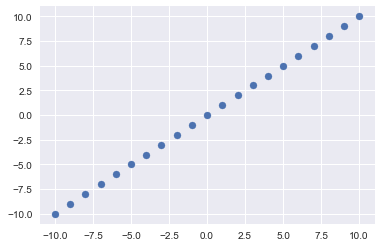

In [5]:
## normal scale
x = np.arange(-10,11)
y = x
plt.scatter(x,y)

In logistic regression, the x and y variables are related by the logit function. 

$$ ln(\frac{p}{(1-p)})=X $$

With a little algebra you could prove the inverse of the logit function is the following:

$$ p = \frac{exp(x)}{(1+exp(x))} $$

In [6]:
## create logit function
def rev_logit(x): 
    return(np.exp(x)/(1+np.exp(x)))

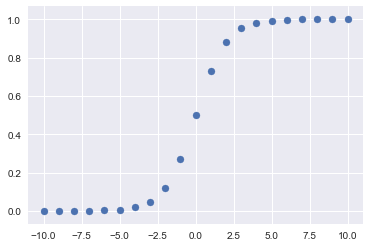

In [7]:
## logit scale
x = np.arange(-10,11)
p = rev_logit(x)
plt.scatter(x,p)

Notice the boundaries of the transformation are 0 and 1, so we would not expect to predict any values smaller than 0 or higher than 1. This is a good trait for an estimator that will be predicting p, the probability of success in the binomial distribution. 

We can use this function to move from the scale of the beta's (inference equation) to the scale of the predicted probability of p. We will come back to this later using data. 

## Other General Linear Models

We can use this idea of a GLM for other models. We must specify the link function and the distribution. Here are a few examples:

* Normal: link = "identity", family=gaussian
* Logistic: link = "logit", family=binomial
* Poisson: link = "log", family=poisson
* Gamma: link = "log", family=Gamma

## Motivating Example: Birthweight Data

We will use the a dataset with a binary outcome as a motivating example. This is a dataset of birth outcomes, with the outcome of interest being low birthweight. You can generalize this setup to any situation with a binary outcome, such as estimating the probability of a customer buying a product, or perhaps the probability of a transaction being fraudulent. 

We will first import this dataset and examine the potential variables. This includes things like age, 

In [8]:
## Set print limits
pd.options.display.max_rows = 10
## Import Data
birthwt = pd.read_csv(r"data\birthwt.csv")
print(birthwt)

     low  age  lwt  race  smoke  ptl  ht  ui  ftv   bwt
0      0   19  182     2      0    0   0   1    0  2523
1      0   33  155     3      0    0   0   0    3  2551
2      0   20  105     1      1    0   0   0    1  2557
3      0   21  108     1      1    0   0   1    2  2594
4      0   18  107     1      1    0   0   1    0  2600
..   ...  ...  ...   ...    ...  ...  ..  ..  ...   ...
184    1   28   95     1      1    0   0   0    2  2466
185    1   14  100     3      0    0   0   0    2  2495
186    1   23   94     3      1    0   0   0    0  2495
187    1   17  142     2      0    0   1   0    0  2495
188    1   21  130     1      1    0   1   0    3  2495

[189 rows x 10 columns]


In [9]:
## Change some categorical variables
birthwt["low_cat"] = pd.Categorical.from_codes(birthwt.low,
                                               categories=["No","Yes"])
birthwt["smoke_cat"] = pd.Categorical.from_codes(birthwt.smoke,
                                                 categories=["No","Yes"])
birthwt["race_cat"] = birthwt["race"].astype('category')

Let's look at an overall description of the dataset to get familiar with it. 

In [10]:
birthwt.describe()

low         age         lwt        race       smoke         ptl  \
count  189.000000  189.000000  189.000000  189.000000  189.000000  189.000000   
mean     0.312169   23.238095  129.814815    1.846561    0.391534    0.195767   
std      0.464609    5.298678   30.579380    0.918342    0.489390    0.493342   
min      0.000000   14.000000   80.000000    1.000000    0.000000    0.000000   
25%      0.000000   19.000000  110.000000    1.000000    0.000000    0.000000   
50%      0.000000   23.000000  121.000000    1.000000    0.000000    0.000000   
75%      1.000000   26.000000  140.000000    3.000000    1.000000    0.000000   
max      1.000000   45.000000  250.000000    3.000000    1.000000    3.000000   

               ht          ui         ftv          bwt  
count  189.000000  189.000000  189.000000   189.000000  
mean     0.063492    0.148148    0.793651  2944.587302  
std      0.244494    0.356190    1.059286   729.214295  
min      0.000000    0.000000    0.000000   709.000000  
25%      0.000000    0.000000    0.000000  2414.000000  
50%      0.000000    0.000000    0.000000  2977.000000  
75%      0.000000    0.000000    1.000000  3487.000000  
max      1.000000    1.000000    6.000000  4990.000000

In [11]:
## Describe Categorical Variables
birthwt.select_dtypes(include=['category']).describe()

low_cat smoke_cat  race_cat
count      189       189       189
unique       2         2         3
top         No        No         1
freq       130       115        96

## Outcome

The outcome of interest is low_cat, the probability of observing a low birthweight. We should start by examining this variable and thinking about what a basic model would look like. If we are estimatign the probability of the outcome == Yes, where should we start?

In [12]:
pd.concat([birthwt.low_cat.value_counts(),
          birthwt.low_cat.value_counts(normalize=True)], axis=1)

low_cat   low_cat
No       130  0.687831
Yes       59  0.312169

We can start by estimating the overall probability of observing outcome == yes. In this case it is .312. In the abscence of any other information, we might expect the probability of observing the outcome to be 31.2%

This is called the 'null model', or the intercept only model. We have no predictors in the model, only a single intercept. 

$$ ln(\frac{p}{(1-p)})=\beta_0$$

Where p is the probability of observing outcome == yes. 

We can actually estimate this basic model using a logistic regression, and then map the resulting parameter estimates.

In [13]:
## Create low == yes variable
birthwt['Low_yes'] = birthwt['low_cat'].map({'Yes': 1, 'No': 0})
## Fit simple logistic regression with only intercept
glm0 = smf.glm('Low_yes ~ 1',
       data=birthwt,
       family=sm.families.Binomial()).fit()
print(glm0.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                Low_yes   No. Observations:                  189
Model:                            GLM   Df Residuals:                      188
Model Family:                Binomial   Df Model:                            0
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -117.34
Date:                Thu, 18 May 2017   Deviance:                       234.67
Time:                        14:46:13   Pearson chi2:                     189.
No. Iterations:                     6                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.7900      0.157     -5.033      0.000        -1.098    -0.482


Let's examine these results to further understand the model we just fit:

$$ ln(\frac{p}{(1-p)})=\beta_0$$

The intercept was estimated to be -0.79, so...

$$ ln(\frac{p}{(1-p)})=-0.79$$

We can use the reverse logit function by solving for p...

$$ p = \frac{exp(-0.79)}{(1+exp(-0.79))} $$

In [14]:
rev_logit(-0.79)

0.31216866941715959

And we have recovered the estimate of p, the probability of observing the outcome. Do you see the connection? Let's add some predictors...

## Logistic Regression with Predictors

We can add predictors into our logistic regression to explore the relationship between the inputs and the outcome. Let's start with another categorical predictor, smoke. First, we create a table of the probabilities of the outcome being observed in each of the predictor categories.

In [15]:
## Smoking by outcome
pd.crosstab(birthwt.smoke_cat,
            birthwt.low_cat,
           normalize=0)

low_cat          No       Yes
smoke_cat                    
No         0.747826  0.252174
Yes        0.594595  0.405405

This table is telling me that the probability of observing the outcome in the smoke == Yes group is 0.405, while the probability of observing the outcome in the smoke == No group is 0.25. It seems like these variables are related. We can fit a logistic regression with smoke as a predictor like so:

In [16]:
## Fit simple logistic regression with only intercept
glm1 = smf.glm('Low_yes ~ smoke_cat',
       data=birthwt,
       family=sm.families.Binomial()).fit()
print(glm1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                Low_yes   No. Observations:                  189
Model:                            GLM   Df Residuals:                      187
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -114.90
Date:                Thu, 18 May 2017   Deviance:                       229.80
Time:                        14:46:14   Pearson chi2:                     189.
No. Iterations:                     6                                         
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           -1.0871      0.215     -5.062      0.000        -1.508    -0.666
smoke_cat[T.Yes]     0.7041      0

The model we just fit is this:

$$ ln(\frac{p}{(1-p)})=\beta_0 + \beta_1*(smoke == yes)$$

The parameter estimates are this:

$$ ln(\frac{p}{(1-p)})=-1.0871 + 0.7041*(smoke == yes)$$

Thus, the probability of outcome == Yes for a non smoker is this:

$$ p=rev\_logit(-1.0871 + 0.7041*(0))$$

In [17]:
rev_logit(-1.0871 + 0.7041*(0))

0.25216476055394227

And the probability of outcome == Yes for a smoker is this:

$$ p=rev\_logit(-1.0871 + 0.7041*(1))$$

In [18]:
rev_logit(-1.0871 + 0.7041*(1))

0.40540353779867699

Which is exactly what we found above! The p-value for the coefficient is 0.028, which is statistically significant if we use the 0.05 cutoff level. Thus, we find evidence that smoking is a risk factor for the bad outcome. 

## Fitting Multiple Predictors

We can fit multiples predictors and perform regression as we have previously learned in the linear model case. Let's include age as a predictor as well. 

In [19]:
## Fit simple logistic regression with only intercept
glm2 = smf.glm('Low_yes ~ smoke + age',
       data=birthwt,
       family=sm.families.Binomial()).fit()
print(glm2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                Low_yes   No. Observations:                  189
Model:                            GLM   Df Residuals:                      186
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -113.64
Date:                Thu, 18 May 2017   Deviance:                       227.28
Time:                        14:46:14   Pearson chi2:                     187.
No. Iterations:                     6                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0609      0.757      0.080      0.936        -1.423     1.545
smoke          0.6918      0.322      2.150      0.0

This model is telling me that age is not a significant predictor of the outcome, after adjusting for smoking status. I conclude this based on the p-value of 0.12, which is below my 0.05 cutoff. However, let's keep it in the model for now as we explore how to make predictions on new data and other ways to summarize the results.

## Odds Ratios

One way in which logistic regression effect sizes are often summarized is the odds ratios. This is accomplished by simply exponentiating a given parameter. In the example above, we may summarize the effects of age like this:

In [20]:
np.exp(glm2.params[1:])

smoke    1.997405
age      0.951439
dtype: float64

The interpreation of these results is the following: The odds of low birthweight are 99% higher for smokers than non-smokers in this dataset. 

We can get 95% confidence intervals around these results and interpret them similarly.

In [21]:
np.exp(glm2.conf_int()[1:])

0         1
smoke  1.063027  3.753081
age    0.893648  1.012968


## Predictions from Logistic Regression

We can score a new dataset using our model, and get a predicted probability of the outcome for a given row of data, considering the model we just fit. In this case we need a new dataset to score. 

In [22]:
new_dat = pd.DataFrame({'smoke':[0,0,0,1,1,1],
                        'age':[15,20,25,15,20,25]})

We must decide on which scale we want to make the predictions. By default, the prediction scale is done on the scale of the betas.

In [23]:
## Prediction on scale of beta
new_dat['Pred_beta'] = glm2.predict(new_dat, linear=True)
new_dat

age  smoke  Pred_beta
0   15      0  -0.685784
1   20      0  -0.934680
2   25      0  -1.183576
3   15      1   0.006065
4   20      1  -0.242831
5   25      1  -0.491728

We can then use our reverse logistic function to recover the actual probabilities:

In [24]:
rev_logit(new_dat.Pred_beta)

0    0.334972
1    0.281976
2    0.234410
3    0.501516
4    0.439589
5    0.379487
Name: Pred_beta, dtype: float64

Alternatively, we can just make the predictions on the probability scale with linear=True

In [25]:
## Prediction on scale of p
new_dat['Pred_p'] = glm2.predict(new_dat,
                                   linear=False)
new_dat

age  smoke  Pred_beta    Pred_p
0   15      0  -0.685784  0.334972
1   20      0  -0.934680  0.281976
2   25      0  -1.183576  0.234410
3   15      1   0.006065  0.501516
4   20      1  -0.242831  0.439589
5   25      1  -0.491728  0.379487